In [73]:
import numpy as np
import matplotlib.pyplot as plt

import tqdm.notebook as tqdm

from util.expectiles import expectile
from util.gmm import GMM

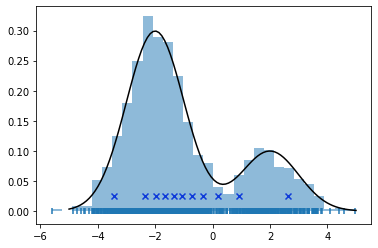

-1.0484118385973877


In [110]:
R = GMM(coeffs=[0.25, 0.75], params=[[2, 1], [-2, 1]])
N = 1000
S = R.rvs(N)
X = np.linspace(-5, 5, 100)
Y = R.pdf(X)
T = np.linspace(0.01, 0.99, 11)
E = expectile(S, T)
plt.hist(S, density=True, alpha=0.5, bins=30)
plt.scatter(S, np.zeros_like(S), marker="|")
plt.plot(X, Y, color="black")
plt.scatter(E, 0.025*np.ones_like(E), marker="x", color="blue")
plt.show()
print(E[5])

In [107]:
class ChainMDP:
    def __init__(self, n=6, r=R):
        self.n = n
        self.r = r
        self.action_space = np.zeros(1)
    def reset(self):
        self.state = 0
        return self.state
    def step(self, action=0):
        self.state += 1
        if self.state == self.n:
            return self.state, self.r.rvs(1)[0], True, {}
        else:
            return self.state, 0, False, {}
    def render(self, end="\r", **kwargs):
        chain = ["(*)" if i == self.state else "( )" for i in range(self.n)]
        chain.append("[*]" if self.n == self.state else "[ ]")
        print("-->"+"-->".join(chain), end=end, **kwargs)
    def close(self):
        print()

env = ChainMDP(6)
done = False
s = env.reset()
env.render()
while not done:
    s, r, done, _ = env.step(0)
    env.render()
env.close()

-->( )-->( )-->( )-->( )-->( )-->( )-->[*]


In [228]:
def train(env, agent, episodes=10000, render=True, log=False):
    if log: history = [agent.state()]
    for _ in tqdm.trange(episodes, unit="eps"):
        s = env.reset()
        done = False
        if render: env.render()
        while not done:
            a = agent.action(s)
            s_, r, done, _ = env.step(a)
            agent.update(s, a, r, s_, done)
            s = s_
            if render: env.render()
        if log: history.append(agent.state())
    if log: return history

In [300]:
class TradRLAgent:
    def __init__(self, n_actions, n_states, alpha=0.001, gamma=0.9):
        self.n = n_states
        self.m = n_actions
        self.Q = np.zeros((self.n, self.m))
        self.alpha = alpha
        self.gamma = gamma
    def action(self, s):
        return np.argmax(self.Q[s])
    def update(self, s, a, r, s_, terminal):
        if terminal:
            self.Q[s, a] += self.alpha * (r - self.Q[s, a])
        else:
            a_ = self.action(s_)
            self.Q[s, a] += self.alpha * (r + self.gamma*self.Q[s_, a_] - self.Q[s, a])
    def render(self):
        print(self.Q)
    def state(self):
        return self.Q.copy()

trlagent = TradRLAgent(1, 6)
trllog = train(ChainMDP(6), trlagent, episodes=20000, render=False, log=True)

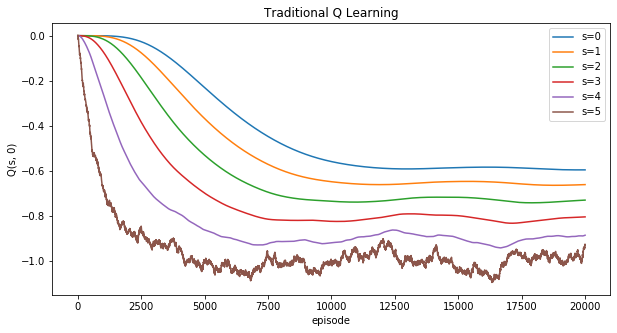

In [301]:
log = np.array(trllog)
plt.figure(figsize=(10, 5))
plt.title("Traditional Q Learning")
for i in range(6):
    plt.plot(log[:, i, 0], label=f"s={i}")
plt.ylabel("Q(s, 0)")
plt.xlabel("episode")
plt.legend()
plt.show()

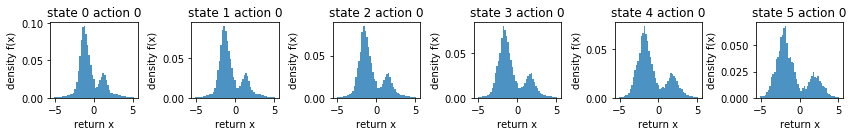

In [331]:
class CDRLAgent:
    def __init__(self, n_actions, n_states, supports, alpha=0.05, gamma=0.9):
        self.n = n_states
        self.m = n_actions
        self.z = supports
        self.k = self.z.size
        self.L = np.zeros((self.n, self.m, self.k)) # logits
        self.dz = np.diff(self.z)
        self.alpha = alpha
        self.gamma = gamma
    def _probs(self, logits):
        probs = np.exp(logits)
        return probs / probs.sum(axis=-1, keepdims=True)
    def action(self, s):
        P = self._probs(self.L[s])
        return np.argmax(P @ self.z)
    def update(self, s, a, r, s_, terminal):
        # follow algorithm 1 in CDRL paper (and EDRL paper)
        # transform:
        if terminal:
            P_ = self._probs(np.zeros_like(self.z))
            w = r * np.ones_like(self.z)
        else:
            a_ = self.action(s_)
            P_ = self._probs(self.L[s_, a_])
            w = r + self.gamma * self.z
        # compute projection:
        Pi = np.zeros_like(self.z)
        l = -1
        for j in range(self.k):
            while l+1 < self.k and self.z[l+1] < w[j]:
                l += 1
            if l < 0:
                Pi[0] += P_[j]
            elif l+1 == self.k:
                Pi[-1] += P_[j]
            elif 0 <= l < self.k-1:
                Pi[l]   += P_[j] * (self.z[l+1] - w[j]) / self.dz[l]
                Pi[l+1] += P_[j] * (w[j] - self.z[l])   / self.dz[l]
            else:
                raise Exception("Algorithm error")
        # step towards target logits according to cross entropy/KL loss
        # (i computed the gradient and this is it!)
        self.L[s, a] -= self.alpha * (self._probs(self.L[s, a]) - Pi)
    def render(self):
        fig, axes = plt.subplots(self.m, self.n, figsize=(2*self.n, 2*self.m))
        P = self._probs(self.L)
        for i in range(self.n):
            for j in range(self.m):
                if self.m > 1:
                    ax = axes[i, j]
                else:
                    ax = axes[i]
                ax.set_title(f"state {i} action {j}")
                ax.set_ylabel("density f(x)")
                ax.set_xlabel("return x")
                ax.bar(self.z, P[i, j], width=self.dz[0], alpha=0.8)
                ax.set_yticks([])
        plt.tight_layout()
        plt.show()
    def state(self):
        return self._probs(self.L)

cdrl_z = np.linspace(-5, 5, 51)
cdrlagent = CDRLAgent(1, 6, supports=cdrl_z)
cdrllog = train(ChainMDP(6), cdrlagent, episodes=20000, render=False, log=True)
cdrlagent.render()

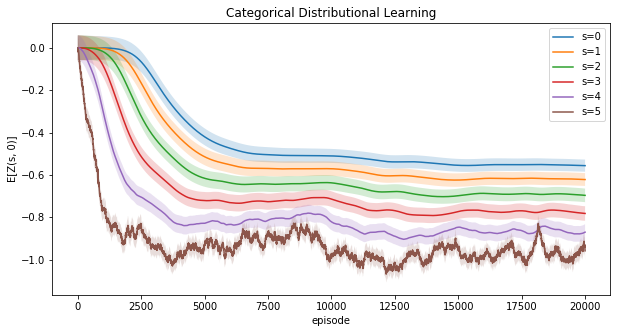

In [333]:
log = np.array(cdrllog)
plt.figure(figsize=(10, 5))
plt.title("Categorical Distributional Learning")
for i in range(6):
    time = np.arange(log.shape[0])
    dist = log[:, i, 0]
    mean = dist @ cdrl_z
    zc = ((cdrl_z - mean[:, np.newaxis])**2)
    sd = np.sqrt((dist[:, np.newaxis] @ zc[:, :, np.newaxis]).squeeze())
    l, = plt.plot(time, mean, label=f"s={i}")
    plt.fill_between(time, mean+0.02*sd, mean-0.02*sd, alpha=0.2, facecolor=l.get_color())
plt.ylabel("E[Z(s, 0)]")
plt.xlabel("episode")
plt.legend()
plt.show()

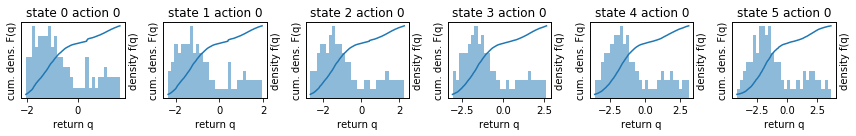

In [354]:
class QDRLAgent:
    def __init__(self, n_actions, n_states, quantile_params, alpha=0.005, gamma=0.9):
        self.n = n_states
        self.m = n_actions
        self.t = quantile_params
        self.k = self.t.size
        self.Q = np.zeros((self.n, self.m, self.k))
        self.Q[:, :] = self.t - 0.5 # initialise to uniform on [-0.5, 0.5]
        self.alpha = alpha
        self.gamma = gamma
    def action(self, s):
        return np.argmax(np.sum(self.Q[s], axis=-1))
    def update(self, s, a, r, s_, terminal):
        # follow algorithm 1 in QDRL paper
        # transform:
        if terminal:            
            T = r * np.ones_like(self.t)
        else:
            a_ = self.action(s_)
            T = r + self.gamma * self.Q[s_, a_]
        # step towards target quantiles according to QR loss
        # NOTE: not using "Quantile Huber Loss" because not doing fn aprx.
        losses_jk = (T[:, None] <= self.Q[s, a]) - self.t
        self.Q[s, a] -= self.alpha / self.k * np.sum(losses_jk, axis=0)
    def render(self):
        pass
        fig, axes = plt.subplots(self.m, self.n, figsize=(2*self.n, 2*self.m))
        for i in range(self.n):
            for j in range(self.m):
                if self.m > 1:
                    ax = axes[i, j]
                else:
                    ax = axes[i]
                ax.set_title(f"state {i} action {j}")
                ax.set_ylabel("cum. dens. F(q)")
                ax.set_xlabel("return q")
                ax.plot(self.Q[i, j], self.t)
                ax2 = ax.twinx()
                ax2.hist(self.Q[i, j], density=True, bins=30, alpha=0.5)
                ax2.set_ylabel("density f(q)")
                ax.set_yticks([])
                ax2.set_yticks([])
        plt.tight_layout()
        plt.show()
    def state(self):
        return self.Q.copy()

qdrl_t = np.linspace(0.01, 0.99, 99)
qdrlagent = QDRLAgent(1, 6, quantile_params=qdrl_t)
qdrllog = train(ChainMDP(6), qdrlagent, episodes=20000, render=False, log=True)
qdrlagent.render()

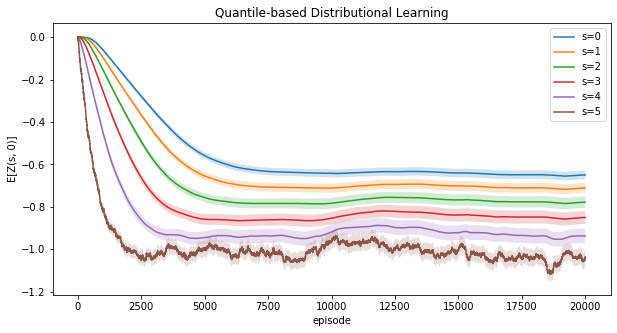

In [355]:
log = np.array(qdrllog)
plt.figure(figsize=(10, 5))
plt.title("Quantile-based Distributional Learning")
for i in range(6):
    time = np.arange(log.shape[0])
    dist = log[:, i, 0]
    mean = np.mean(dist, axis=-1)
    sd = np.std(dist, axis=-1)
    l, = plt.plot(time, mean, label=f"s={i}")
    plt.fill_between(time, mean+0.02*sd, mean-0.02*sd, alpha=0.2, facecolor=l.get_color())
plt.ylabel("E[Z(s, 0)]")
plt.xlabel("episode")
plt.legend()
plt.show()

## TODO:

* 'Naive' expectile-based DistRL
* Expectile-based DistRL with DeepMind imputation
* Expectile-based DistRL with direct imputation